 ## Mann Kendal trend analysis 

In [1]:
from osgeo import gdal_array
from osgeo import gdal
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from matplotlib.colors import ListedColormap
import statsmodels.api as sm
import pymannkendall as mk
import rasterio
from rasterio.features import geometry_mask
from rasterio.features import geometry_window
from rasterio.transform import from_origin
import shutil
import pandas as pd
import geopandas as gpd

# Rasters reading

In [2]:
#reading rasters

no_data = 255.0
nb_factors, nb_pixels_height, nb_pixels_width = 2, 126, 229
start_year = 2008
end_year = 2022
nb_years = end_year - start_year + 1
years = np.array([start_year+i for i in range(nb_years)])

factors_str = ["Precipitation", "Soil moisture"]

#load rasters into arrays

#independent variables (X)
# factors[0] : precipitation
# factors[1] : soil moisture
factors = np.ndarray((nb_factors,nb_years,nb_pixels_height,nb_pixels_width))

index_start_year = start_year - 2002
index_end_year = 21 - (2022 - end_year)
#precipitation data
data = gdal_array.LoadFile("./rasters/raster-total_precipitation_5km.tif")
factors[0] = data[index_start_year:index_end_year]
#soil moisture data
data = gdal_array.LoadFile("./rasters/raster-volumetric_soil_water_layer_1_5km.tif")
factors[1] = data[index_start_year:index_end_year]

#dependent variables (Y)
#vegetation index
vegetation_index = np.ndarray((nb_years,nb_pixels_height,nb_pixels_width))
for i,y in enumerate(years):
    vegetation_index[i] = gdal_array.LoadFile(f"./rasters/vegetation_cont_5km_{y}.tif")

In [3]:
valid_data_mask = (vegetation_index[0] != no_data)
valid_data_mask_tiled = (vegetation_index != no_data)

In [4]:
#number of valid pixels (different than no_data)
steppe_area = np.count_nonzero(valid_data_mask)*25
print(f"Number of valid pixels: {np.count_nonzero(valid_data_mask)} ({steppe_area} km2)")

Number of valid pixels: 13742 (343550 km2)


# Standardization

In [5]:
def strandardize(arr):
    # Extract valid data values
    valid_data = arr[valid_data_mask_tiled]
    # Calculate mean and standard deviation of valid data
    mean_value = np.mean(valid_data)
    std_dev_value = np.std(valid_data)
    # Standardize valid data
    standardized_data = (valid_data - mean_value) / std_dev_value
    # Replace standardized values in the original data
    arr[valid_data_mask_tiled] = standardized_data
    return arr

In [6]:
# for f in range(nb_factors):
#      factors[f]= strandardize(factors[f])
# vegetation_index = strandardize(vegetation_index)

# Normalization

In [7]:
def normalize(arr):
    # Extract valid data values
    valid_data = arr[valid_data_mask_tiled]   
    # Calculate the minimum and maximum values    
    min_value = np.min(valid_data)
    max_value = np.max(valid_data)
    # Normalize the array
    normalized_array = (valid_data - min_value) / (max_value - min_value)
    # Replace normalized values in the original data
    arr[valid_data_mask_tiled] = normalized_array
    return arr

In [8]:
for f in range(nb_factors):
    factors[f]= normalize(factors[f])
vegetation_index = normalize(vegetation_index)

# Calculations

The used LinearRegression method minimizes the residual sum of squares between the observed targets in the dataset, and the targets predicted by the linear approximation.
For each pixel and each factor:
* Perform a linear regression of the vegetation index against the factor
* Get the residues of the linear regression

In [9]:
residuals = np.full((nb_factors,nb_years,nb_pixels_height,nb_pixels_width),no_data)

alpha = 0.05

for i in range(nb_pixels_height):
    for j in range(nb_pixels_width):
        if (valid_data_mask[i,j]):
            for f in range(nb_factors):
                #linear regression of vegetation index against factor[f]
                FACTOR = sm.add_constant(factors[f,:,i,j])
                model = sm.OLS(vegetation_index[:,i,j], FACTOR).fit()
                residuals[f,:,i,j] = model.resid                

In [10]:
avg_residue = np.ndarray((nb_factors,nb_years))
for f in range(nb_factors):
    for y in range(nb_years):
        avg_residue[f,y] = np.average(residuals[f,y][valid_data_mask])    

# Mann-Kendal Non-Parametric Trend Analysis

In [11]:
for f in range(nb_factors):
    results = mk.original_test(avg_residue[f])

    # Output the results
    print(f"\n******** Factor {factors_str[f]}:")
    print(f"Kendall's Tau: {results.Tau}")
    print(f"P-Value: {results.p}")
    print(f"Trend : {results.trend}")


******** Factor Precipitation:
Kendall's Tau: -0.21904761904761905
P-Value: 0.2762784158080178
Trend : no trend

******** Factor Soil moisture:
Kendall's Tau: -0.1619047619047619
P-Value: 0.42848041949799653
Trend : no trend


In [12]:
mk_trend = np.full((nb_factors, nb_pixels_height, nb_pixels_width),255)

for f in range(nb_factors):
    kt_list = []
    sig_neg_pixels = []
    sig_pos_pixels = []
    for i in range(nb_pixels_height):
        for j in range(nb_pixels_width):
            if valid_data_mask[i,j]:
                results = mk.original_test(residuals[f,:,i,j].tolist())
                kt_list.append((results.Tau,results.p))
                if results.p < alpha:
                    if results.Tau < 0:
                        sig_neg_pixels.append((i,j))
                        mk_trend[f,i,j] = 1
                    else:
                        sig_pos_pixels.append((i,j))
                        mk_trend[f,i,j] = 0
                else:
                    mk_trend[f,i,j] = 0

    print(f"\n******** Factor {factors_str[f]}:")
    print(f"Average Kendall's Tau: {sum(t[0] for t in kt_list)/len(kt_list)}")
    print(f"Average p-value: {sum(t[1] for t in kt_list)/len(kt_list)}")
    print(f"Number of pixels with significant negative trend: {len(sig_neg_pixels)} - Area: {len(sig_neg_pixels)*25} km² ({len(sig_neg_pixels)*2500/steppe_area:.2f}% of the steppe)")
    print(f"Number of pixels with significant positive trend: {len(sig_pos_pixels)} - Area: {len(sig_pos_pixels)*25} km² ({len(sig_pos_pixels)*2500/steppe_area:.2f}% of the steppe)")
    print("---------------------------------")        
                


******** Factor Precipitation:
Average Kendall's Tau: -0.148846428398165
Average p-value: 0.456028457977053
Number of pixels with significant negative trend: 875 - Area: 21875 km² (6.37% of the steppe)
Number of pixels with significant positive trend: 5 - Area: 125 km² (0.04% of the steppe)
---------------------------------

******** Factor Soil moisture:
Average Kendall's Tau: -0.13197635334150842
Average p-value: 0.49223892799511243
Number of pixels with significant negative trend: 170 - Area: 4250 km² (1.24% of the steppe)
Number of pixels with significant positive trend: 3 - Area: 75 km² (0.02% of the steppe)
---------------------------------


In [13]:
masked_mk_trend = np.ma.masked_where(mk_trend == no_data, mk_trend) 

In [14]:
labels_significant = ["Not negative significant", "Negative significant"]

In [15]:
def patch(arr,labels):
    values = np.unique(arr[valid_data_mask])
    colors = [im.cmap(im.norm(value)) for value in values]
    patches = []
    for i in values:
        i = int(i)
        patches.append(mpatches.Patch(color=colors[i], label=labels[i]))
    return patches

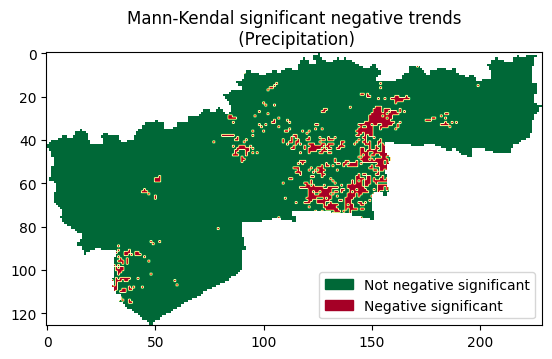

In [16]:
im = plt.imshow(masked_mk_trend[0], cmap="RdYlGn_r")
plt.legend(handles=patch(mk_trend[0],labels_significant), loc='lower right' )
plt.title(f'Mann-Kendal significant negative trends\n ({factors_str[0]})')
plt.show()
# unique, counts = np.unique(mk_trend[0], return_counts=True)
# results = dict(zip(unique.astype(int), counts))
# print(f"Repartition of pixels: {results}")
# print(f"Total area with significative negative trend: {results[1]*25} km² ({results[1]*2500/steppe_area:.2f}% of the steppe)")

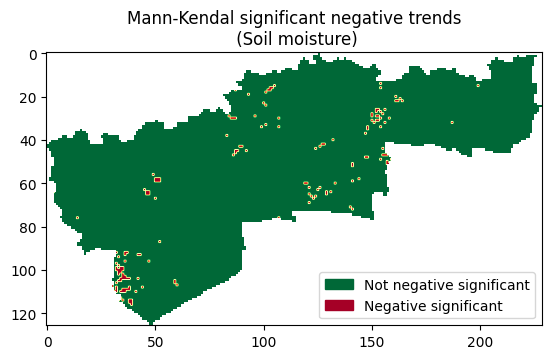

In [17]:
im = plt.imshow(masked_mk_trend[1], cmap="RdYlGn_r")
plt.legend(handles=patch(mk_trend[1],labels_significant), loc='lower right' )
plt.title(f'Mann-Kendal significant negative trends\n ({factors_str[1]})')
plt.show()
# unique, counts = np.unique(mk_trend[1], return_counts=True)
# results = dict(zip(unique.astype(int), counts))
# print(f"Repartition of pixels: {results}")
# print(f"Total area with significative negative trend: {results[1]*25} km² ({results[1]*2500/steppe_area:.2f}% of the steppe)")

# Raster export

Export numpy array to a raster by coping an existing one and updating it (to keep metadata).

In [18]:
def duplicate_file(source_path, destination_path):
    try:
        # Copy the file from source_path to destination_path
        shutil.copy2(source_path, destination_path)
    except Exception as e:
        print(f"Error duplicating file: {e}")

In [19]:
def export_raster(path,new_path,arr):
    duplicate_file(path,new_path)
    # Open the raster file in read-write mode
    with rasterio.open(new_path, 'r+') as src:
        # Read the raster data as a NumPy array
        data = src.read(1)

        # Replace the old content
        data = arr

        # Write the modified array back to the raster
        src.write(data, 1)

In [20]:
#Export array to the .tiff file.
export_raster("original.tiff","neg_trends_"+str(start_year)+"_"+str(end_year)+".tiff",mk_trend[0])

In [21]:
def count_pixels(tiff_path, shapefile_path, attribute_field, target_pixel_value):
    # Step 1: Read TIFF file
    with rasterio.open(tiff_path) as src:
        raster_profile = src.profile
        raster_data = src.read(1)  # Assuming a single-band raster
        
    transform = src.transform
    out_shape = raster_data.shape    

    # Step 2: Read Shapefile and select features based on attribute
    gdf = gpd.read_file(shapefile_path)
    gdf = gdf.to_crs(epsg=4326)
    # Step 3: Count pixels with the specified value in selected features
    wilayas = []
    pixels_count = []
    areas = []
    degraded_area = []
    degradation_per = []
    total_area = 0

    for index, feature in gdf.iterrows():
        # Use the original feature geometry as the mask
        mask = geometry_mask([feature.geometry], out_shape=out_shape, transform=src.transform, invert=True)
        # Count pixels with the specified value inside the feature geometry
        count = (raster_data[mask] == target_pixel_value).sum()
        # The Wilaya area is obtained by counting pixels from raster_data[mask] with data
        area = (raster_data[mask] != no_data).sum()
    
        if count != 0 :                 
            total_area += area
            wilayas.append(feature['ADM1_EN'])
            pixels_count.append(count)
            areas.append(area*25)
            degraded_area.append(count*25) 
            degradation_per.append(count*100/(area))
        
    results = pd.DataFrame({"wilaya":wilayas,
                            "count":pixels_count,
                            "area":areas,
                            "degraded area":degraded_area, 
                            "degradation":degradation_per})
    return results

#### Remarks:
* 80 pixels at the border of the steppic region are not taken into account since their center does not belong steppic map shape file (2000km²).
* For every Wilaya, only the area belonging to the steppic region is given. The degradation percentage is calculated accordigly.

In [22]:
tiff_file_path = "./neg_trends_"+str(start_year)+"_"+str(end_year)+".tiff"
shapefile_path = "/home/eoafrica/shared/Datasets/shapefiles_algeria/dza_admbnda_unhcr2020_shp/dza_admbnda_adm1_unhcr_20200120.shp"
attribute_name = "ADM1_EN"
target_pixel_val = 1 
results = count_pixels(tiff_file_path, shapefile_path, attribute_name, target_pixel_val).sort_values('degradation', ascending =False)
results

,wilaya,count,area,degraded area,degradation
0,Ain-Defla,1,100,25,25.000000
3,Biskra,256,26075,6400,24.544583
6,El Oued,13,1425,325,22.807018
2,Bechar,9,1300,225,17.307692
4,Djelfa,260,39250,6500,16.560510
12,Ouargla,2,400,50,12.500000
1,Batna,56,15075,1400,9.286899
9,Laghouat,122,33150,3050,9.200603
10,M'Sila,45,21900,1125,5.136986
7,Ghardaia,3,1550,75,4.838710
